In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from mlxtend.data import loadlocal_mnist

In [2]:
np.random.seed(10)

In [3]:
def process_mnist_data() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    mnist_path = './MNIST/'
    train_images, train_labels = loadlocal_mnist(
        images_path = mnist_path + './train-images.idx3-ubyte',
        labels_path = mnist_path + './train-labels.idx1-ubyte'
    )
    test_images, test_labels = loadlocal_mnist(
        images_path = mnist_path + './t10k-images.idx3-ubyte',
        labels_path = mnist_path + './t10k-labels.idx1-ubyte'
    )
    return train_images, train_labels, test_images, test_labels

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [5]:
def process_cifar_dataset() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    cifar_path = './cifar-10-python/cifar-10-batches-py'
    data_batch = unpickle(cifar_path + '/data_batch_1')
    train_images, train_labels = data_batch[b'data'], np.array(data_batch[b'labels'])
    for i in range(2,6):
        data_batch = unpickle(cifar_path + '/data_batch_' + str(i))
        train_images = np.concatenate((train_images, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.array(data_batch[b'labels'])), axis=0)
    test_batch = unpickle(cifar_path + '/test_batch')
    test_images, test_labels = test_batch[b'data'], np.array(test_batch[b'labels'])
    return train_images, train_labels, test_images, test_labels

In [6]:
def process_toy_dataset():
    toy_dataset_path = './Toy Dataset/'
    a = np.loadtxt(toy_dataset_path + 'trainNN.txt')
    b = np.loadtxt(toy_dataset_path + 'testNN.txt')
    train_x, train_y, test_x, test_y = a[:, 0:4], a[:, -1], b[:, 0:4], b[:, -1]
    return train_x, train_y, test_x, test_y

In [7]:
def parse_input_model():
    path = './input_model.txt'
    model = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            if tokens[0] == 'Conv':
                model.append(ConvolutionLayer(int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4])))
            if tokens[0] == 'ReLU':
                model.append(ActivationLayer())
            if tokens[0] == 'Pool':
                model.append(MaxPoolingLayer(int(tokens[1]), int(tokens[2])))
            if tokens[0] == 'FC':
                model.append(FlatteningLayer())
                model.append(FullyConnectedLayer(int(tokens[1])))
            if tokens[0] == 'Softmax':
                model.append(SoftmaxLayer())
        return model

In [8]:
def relu(matrix:np.ndarray) -> np.ndarray:
    return matrix * (matrix > 0)

In [9]:
class ConvolutionLayer:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding

    def forward(self, input_image: np.ndarray) -> np.ndarray:
        input_dimentions = input_image.shape[0]
        output_dimentions = (input_dimentions - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_image.shape

        filters = np.random.rand(
            self.output_channel_count,
            self.filter_dimension,
            self.filter_dimension,
            input_shape[2]
        )

        bias = np.random.rand(self.output_channel_count)

        padded_image = np.pad(input_image, [(self.padding,self.padding), (self.padding,self.padding), (0,0)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((output_dimentions, output_dimentions, self.output_channel_count))

        # for i in range(self.output_channel_count):
        #     image_y = out_y = 0
        #     while image_y + self.filter_dimension <= padded_dimensions[1]:
        #         image_x = out_x = 0
        #         while image_x + self.filter_dimension <= padded_dimensions[0]:
        #             image_slice = padded_image[image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension, :]
        #             output[out_x, out_y, i] = np.sum(image_slice * filters[i, :, :, :]) + bias[i]
        #             image_x += self.stride
        #             out_x += 1
        #         image_y += self.stride
        #         out_y += 1

        image_y = out_y = 0
        while image_y + self.filter_dimension <= padded_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= padded_dimensions[0]:
                image_slice = padded_image[image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.sum(image_slice * filters) + bias
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [10]:
class ActivationLayer:
    def __init__(self):
        pass

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        return relu(input_matrix)

    def backward(self):
        pass

In [11]:
class MaxPoolingLayer:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        output_dimension = (input_dimensions[0] - self.filter_dimension) // self.stride + 1

        output = np.zeros((output_dimension, output_dimension, input_dimensions[2]))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= input_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= input_dimensions[0]:
                image_slice = image[image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.max(image_slice, axis=(0, 1))
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [12]:
class FlatteningLayer:
    def __init__(self):
        pass

    def forward(self, image: np.ndarray) -> np.ndarray:
        return image.flatten().reshape(-1, 1)

    def backward(self):
        pass

In [13]:
class FullyConnectedLayer:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        weights = np.random.rand(flattened_input.shape[0], self.output_dimension)
        bias = np.random.rand(self.output_dimension, 1)

        return weights.T @ flattened_input + bias

    def backward(self):
        pass

In [14]:
class SoftmaxLayer:
    def __init__(self):
        pass

    def forward(self, input_matrix: np.ndarray):
        exp = np.exp(input_matrix)
        exp /= np.sum(exp)
        return exp

    def backward(self):
        pass

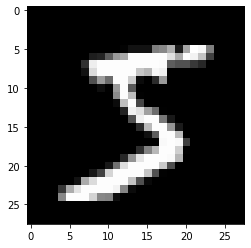

In [15]:
x_train, y_train, x_test, y_test = process_mnist_data()
img = x_train[0].reshape(28, 28, 1)
plt.imshow(img, cmap='gray')

In [16]:
m = parse_input_model()
mnist_batch_1 = x_train[0:64].reshape(64, 28, 28, 1)
o = m[0].forward(mnist_batch_1[0,:,:,:])
o[:, :, 0]

array([[ 0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524],
       [ 0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524],
       [ 0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.43960524,  0.43960524,  0.43960524,  0.43960524,
         0.43960524,  0.4396